# How to: Build a simple neural network with TensorFlow Eager

Hello everyone! In this tutorial we are going to build a simple feedforward neural network
using the imperative mode of TensorFlow. Hope you will find it useful! If you have any suggestions on how I can improve the code, please let me know. 

**Version used: TensorFlow 1.7**

## Step 1: Import useful libraries and enable eager mode
----

In [2]:
# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import function to generate toy classication problem
from sklearn.datasets import make_moons
import numpy as np

# Import library for plots
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Enable eager mode. Once activated it cannot be reversed! Run just once.
tfe.enable_eager_execution()

## Step 2: Generate toy dataset for binary classification
----
We will generate a toy dataset, to train our network. I chose the make_moons function from sklearn. I believe it is perfect for our task, as the classes are not linearly separable so a neural network will be very useful.

In [4]:
# Generate toy dataset for classification
# X is a matrix of n_samples x n_features and represents the input features
# y is a vector with length n_samples and represents our targets
X, y = make_moons(n_samples=100, noise=0.1, random_state=2018)

## Step 3: Visualize generated dataset
----

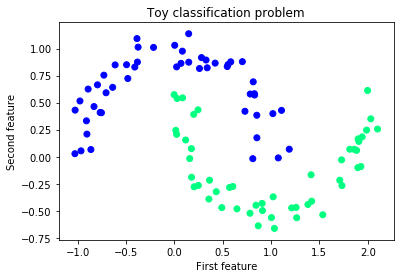

In [5]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.winter)
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.title('Toy classification problem')
plt.show()

## Step 4: Build a single hidden layer neural  network (Linear -> ReLU -> Linear output)
----
Our first trial is a simple neural network with a single hidden layer. The easiest way to build neural networks models with TensorFlow Eager is with classes. During initialization, you define the layers needed to run a forward-pass through the model.

As this is a classification problem, we will be using the softmax cross-entropy loss. Normally, we would have to one-hot encode our targets. To avoid this, we will be using the sparse softmax loss, which takes as an input the raw targets. No need for further processing! HOORAY :).


In [6]:
class simple_nn(tf.keras.Model):
    def __init__(self):
        super(simple_nn, self).__init__()
        """ Define here the layers used during the forward-pass 
            of the neural network.
        """   
        # Hidden layer.
        self.dense_layer = tf.layers.Dense(10, activation=tf.nn.relu)
        # Output layer. No activation.
        self.output_layer = tf.layers.Dense(2, activation=None)
    
    def predict(self, input_data):
        """ Runs a forward-pass through the network.     
            Args:
                input_data: 2D tensor of shape (n_samples, n_features).   
            Returns:
                logits: unnormalized predictions.
        """
        hidden_activations = self.dense_layer(input_data)
        logits = self.output_layer(hidden_activations)
        return logits
    
    def loss_fn(self, input_data, target):
        """ Defines the loss function used during 
            training.         
        """
        logits = self.predict(input_data)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=target, logits=logits)
        return loss
    
    def grads_fn(self, input_data, target):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tfe.GradientTape() as tape:
            loss = self.loss_fn(input_data, target)
        return tape.gradient(loss, self.variables)
    
    def fit(self, input_data, target, optimizer, num_epochs=500, verbose=50):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs.
        """
        for i in range(num_epochs):
            grads = self.grads_fn(input_data, target)
            optimizer.apply_gradients(zip(grads, self.variables))
            if (i==0) | ((i+1)%verbose==0):
                print('Loss at epoch %d: %f' %(i+1, self.loss_fn(input_data, target).numpy()))

## Step 5: Train the model with gradient descent
----
Use backpropagation to train the variables of our model. Feel free to play with the learning rate and the number of epochs.

In [9]:
X_tensor = tf.constant(X)
y_tensor = tf.constant(y)

In [11]:
optimizer = tf.train.GradientDescentOptimizer(5e-1)
model = simple_nn()
model.fit(X_tensor, y_tensor, optimizer, num_epochs=500, verbose=50)

Loss at epoch 1: 0.602928
Loss at epoch 50: 0.250671
Loss at epoch 100: 0.207650
Loss at epoch 150: 0.161135
Loss at epoch 200: 0.118576
Loss at epoch 250: 0.088232
Loss at epoch 300: 0.067111
Loss at epoch 350: 0.052502
Loss at epoch 400: 0.042231
Loss at epoch 450: 0.035105
Loss at epoch 500: 0.029945


## Step 7: Plot decision boundary
----
The code for visualizing the decision boundary of our model has been inspired from [this tutorial](http://scikit-learn.org/stable/auto_examples/svm/plot_iris.html#sphx-glr-auto-examples-svm-plot-iris-py).

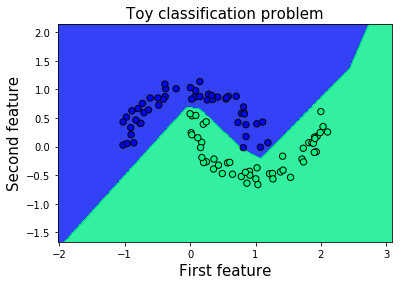

In [13]:
# Create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Predict target for each sample xx, yy
Z = np.argmax(model.predict(tf.constant(np.c_[xx.ravel(), yy.ravel()])).numpy(), axis=1)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.winter, alpha=0.8)

# Plot our training points
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.winter, edgecolors='k')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xlabel('First feature', fontsize=15)
plt.ylabel('Second feature', fontsize=15)
plt.title('Toy classification problem', fontsize=15)
plt.show()